# Feature Selection

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from config import *

In [2]:
features_raw = pd.read_parquet(FEATURES_DIR / "features.pq")
features_raw.shape

(192, 520)

In [3]:
# Drop participants where all features are null
features = features_raw[~(features_raw.isna().sum(axis=1) == features_raw.shape[1]-2)]
features.shape

(171, 520)

In [17]:
y = pd.DataFrame(features["y"], columns=["y"])
X = features.drop(["participant_id", "y"], axis=1)
X.shape

(171, 518)

## Criteria 1: Minimum accepted variance of features

$$
v_f < mav = 0.01
$$

In [5]:
from sklearn.feature_selection import VarianceThreshold

In [6]:
def remove_low_variance_features(X, threshold=0.01):
    """
    Remove features with variance below a specified threshold.
    
    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    threshold : float, optional (default=0.01)
        Variance threshold below which features will be removed
        
    Returns:
    --------
    X_reduced : DataFrame
        Feature matrix with low variance features removed
    """
    # Apply variance threshold
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)

    # Get selected feature names
    selected_feature_names = X.columns[selector.get_support()]

    # Create reduced DataFrame
    X_reduced = X[selected_feature_names]

    logging.info(f"Kept {X_reduced.shape[1]} features out of {X.shape[1]}")
    
    return X_reduced

## Criteria 2: Maximum accepted correlation of features

$$
r_{f_{x}f_{y}} < mac = 0.85
$$

In [7]:
def remove_multicollineraity(X, y, feature_corr_threshold=0.85,verbose=True):
    """
    Remove highly correlated features while prioritizing features with higher correlation to target.
    
    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : Series or DataFrame
        Target variable
    feature_corr_threshold : float, optional (default=0.85)
        Threshold above which features are considered highly correlated
    verbose : bool, optional (default=True)
        Whether to print information about dropped features
        
    Returns:
    --------
    X_reduced : DataFrame
        Feature matrix with highly correlated features removed
    """
    # Covert y to series
    y = y.iloc[:,0]
    
    # Calculate feature-feature correlation matrix
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Calculate feature-target correlation
    corr_with_y = pd.DataFrame(X.corrwith(y).abs(), columns=["Corr"])
    
    # Add variance as secondary criterion for tie-breaking
    corr_with_y["Variance"] = X.var().values
    
    # Sort by correlation with target (primary) and variance (secondary)
    corr_with_y_sorted = corr_with_y.sort_values(
        by=["Corr", "Variance"], ascending=[False, False]
    )

    # Remove highly correlated features
    to_drop = set()
    for column in corr_with_y_sorted.index:
        if column in to_drop:
            continue
        
        # Find highly correlated features
        corr_features = upper.index[upper[column] > 0.85].tolist()
        
        for corr_feature in corr_features:
            if corr_feature not in to_drop:
                to_drop.add(corr_feature)

    X_reduced = X.drop(columns=list(to_drop))

    logging.info(f"Removed {len(to_drop)} highly correlated features: {to_drop}")
    
    return X_reduced

In [8]:
X_reduced = X.pipe(remove_low_variance_features).pipe(remove_multicollineraity, y)

2025-05-02 08:47:42,865 - INFO - 2232154314.remove_low_variance_features:27 - Kept 493 features out of 518


2025-05-02 08:47:43,235 - INFO - 3036117033.remove_multicollineraity:54 - Removed 175 highly correlated features: {'EVIL_BASTARD_fixations_per_second_max', 'SHAPES_distance_to_fixpoint_x_mean', 'SHAPES_duration_mean_sacc', 'SHAPES_fixation_distance_std', 'SHAPES_fixations_per_second_max', 'FITTS_LAW_fixations_per_second_mean', 'KING_DEVICK_x_acceleration_median', 'KING_DEVICK_Var_total', 'ANTI_SACCADE_total_acceleration_magnitude_median', 'ANTI_SACCADE_total_acceleration_magnitude_mean', 'FIXATIONS_distance_to_fixpoint_mean', 'EVIL_BASTARD_duration_mean_fix', 'EVIL_BASTARD_fixations_per_second_mean', 'REACTION_duration_max_fix', 'SMOOTH_PURSUITS_duration_max_fix', 'SHAPES_avg_pupil_size_median_fix', 'SHAPES_distance_to_fixpoint_median', 'FIXATIONS_fixations_per_second_mean', 'ANTI_SACCADE_avg_pupil_size_mean_fix', 'FITTS_LAW_avg_pupil_size_max_fix', 'KING_DEVICK_duration_max_fix', 'EVIL_BASTARD_Var_total', 'SHAPES_fixations_per_second_median', 'FIXATIONS_saccades_per_second_max', 'EVIL

In [9]:
X_reduced.shape

(171, 318)

In [18]:
def remove_low_correlation_features(X, y, threshold=0.1):
    """
    Removes features from X that have an absolute correlation with y below the specified threshold.
    
    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series or pd.DataFrame): Target variable.
        threshold (float): Minimum absolute correlation required to keep a feature.
        
    Returns:
        pd.DataFrame: Reduced feature matrix with low-correlation features removed.
    """
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]  # Convert to Series if needed

    corr_with_y = pd.DataFrame(X.corrwith(y).abs(), columns=["Corr"])
    to_drop = corr_with_y[corr_with_y["Corr"] < threshold].index
    X_reduced = X.drop(columns=to_drop)

    return X_reduced

In [19]:
X3 = remove_low_correlation_features(X_reduced, y)

In [20]:
X3.shape

(171, 104)

## 2-sample Mann-Whitney U test

In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [80]:
def find_statistically_different_features(X, y, alpha=0.05, return_details=False):
    """
    Identify features that show statistically significant differences between two groups.
    
    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : Series or DataFrame
        Binary target variable (0/1 or similar)
    alpha : float, optional (default=0.05)
        Significance level threshold
        
    Returns:
    --------
    significant_features : list or DataFrame
        If return_details=False, returns list of feature names
        If return_details=True, returns DataFrame with features, p-values, and test statistics
    """
    # Convert y to series
    y = y.iloc[:, 0]
    
    # Merge data for filtering
    data = X.copy()
    data['y'] = y
    
    control = data[data['y'] == 0]
    patient = data[data['y'] == 1]
    
    test_statistics = []

    for feature in X.columns:
        
        if feature in ["participant_id", 'y']:
            continue
        
        control_values = control[control[feature].notna()][feature]
        patient_values = patient[patient[feature].notna()][feature]
        
        U_value, p_value = stats.mannwhitneyu(control_values, patient_values)
        
        # Save test statistics
        test_statistics.append({
            'feature': feature,
            'p_value': p_value,
            'U_value': U_value,
            'mean_control': float(np.nanmean(control_values)),
            'mean_patient': float(np.nanmean(patient_values)),
            'std_control': float(np.nanstd(control_values)),
            'std_patient': float(np.nanstd(patient_values))
        })
    
    # Convert to DataFrame
    test_statistics = pd.DataFrame(test_statistics)
    if len(test_statistics) > 0:
        test_statistics = test_statistics.sort_values('p_value')         

    # Get significant features
    reject, p_values_corrected, _, _ = multipletests(test_statistics["p_value"], alpha=alpha, method='fdr_bh')
    test_statistics["p_value_corrected"] = p_values_corrected
    significant_features = test_statistics[reject]

    logging.info(f"Found {len(significant_features)} significant features.")

    if not return_details:
        significant_features = significant_features["feature"]

    return significant_features

In [88]:
significant_features = find_statistically_different_features(X_reduced, y, alpha=0.05, return_details=False)

2025-05-02 09:50:26,771 - INFO - 1831192782.find_statistically_different_features:63 - Found 6 significant features.


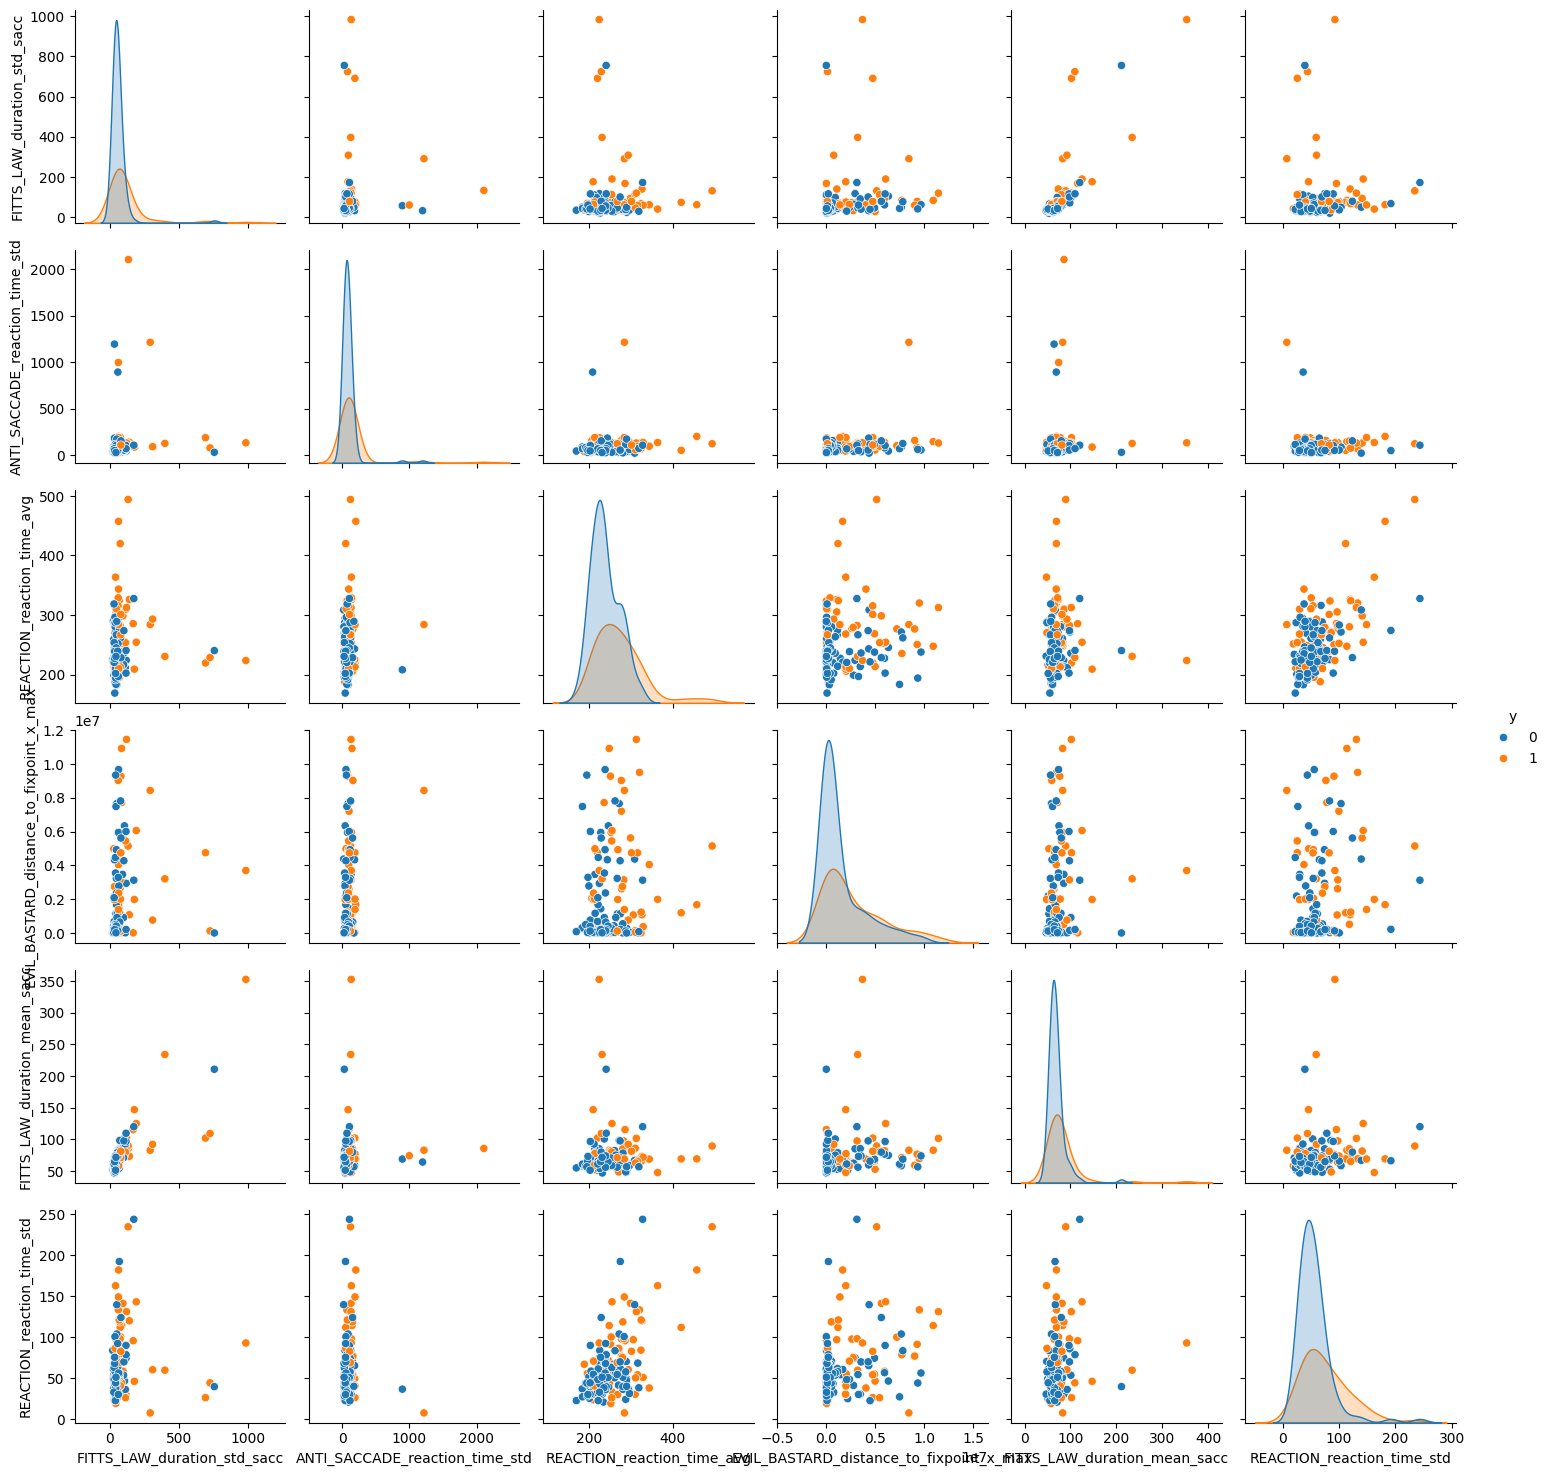

In [84]:
top_10_features_significance = list(significant_features.sort_values("p_value")["feature"])
sns.pairplot(features[top_10_features_significance + ['y']], hue='y')

In [91]:
set(significant_features)

{'ANTI_SACCADE_reaction_time_std',
 'EVIL_BASTARD_distance_to_fixpoint_x_max',
 'FITTS_LAW_duration_mean_sacc',
 'FITTS_LAW_duration_std_sacc',
 'REACTION_reaction_time_avg',
 'REACTION_reaction_time_std'}

## Random forest

In [233]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from kneed import KneeLocator

In [269]:
def get_feature_importance(X, y, by_experiment, cv=5, n_jobs=-1, random_state=42):
    """
    Calculate feature importance for each experiment by training optimized models on experiment-specific features.
    
    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : Series or DataFrame
        Target variable
    experiments : list, optional (default=None)
        List of experiment prefixes to group features by. If None, will try to infer from column names.
    cv : int, optional (default=5)
        Number of cross-validation folds
    n_jobs : int, optional (default=-1)
        Number of parallel jobs for GridSearch and RandomForest
    random_state : int, optional (default=42)
        Random seed for reproducibility
        
    Returns:
    --------
    feature_importances : DataFrame
        DataFrame with feature importances for each feature
    best_params : dict
        Dictionary mapping experiment names to their best parameters
    """
    if by_experiment:
        experiments = ["ANTI_SACCADE", "FITTS_LAW", "FIXATIONS", "KING_DEVICK", "EVIL_BASTARD", "REACTION", "SHAPES", "SMOOTH_PURSUITS"]
    else:
        experiments = ["ALL"]

    # Convert y to correct format
    y = y.values.ravel()

    # Initialize results
    feature_importances = pd.DataFrame(
        np.zeros(X.shape[1]), 
        columns=["Importance"], 
        index=X.columns)
    best_params = {}
    
    for exp in experiments:
        if exp == "ALL":
            exp_features = X.columns
            X_exp = X
        else:
            exp_features = [f for f in X.columns if exp in f]
            X_exp = X[exp_features]
        
        # Hyperparameters for GridSearch
        parameters = {
            'max_depth': [None, 3, 5, 7, 9, 11],
            'n_estimators': [20, 30, 40, 50, 70, 100],
            'max_features': ['sqrt', 'log2', None]
        }

        # Find best clf
        grid_search = GridSearchCV(
            RandomForestClassifier(n_jobs=n_jobs, random_state=random_state), 
            parameters, 
            cv=cv, 
            verbose=0, 
            n_jobs=n_jobs)
        grid_search.fit(X_exp, y)
        
        best_model = grid_search.best_estimator_
        importances = best_model.feature_importances_
        best_params[exp] = grid_search.best_params_
        
        # update importances
        feature_importances.loc[exp_features, "Importance"] += importances
    
    return feature_importances, best_params

In [ ]:
feature_importances_exp, best_params_exp = get_feature_importance(X_reduced, y, by_experiment=True)
feature_importances, best_params = get_feature_importance(X_reduced, y, by_experiment=False)

In [300]:
best_params_exp

{'ANTI_SACCADE': {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 30},
 'FITTS_LAW': {'max_depth': 3, 'max_features': None, 'n_estimators': 100},
 'FIXATIONS': {'max_depth': 5, 'max_features': None, 'n_estimators': 100},
 'KING_DEVICK': {'max_depth': 5, 'max_features': None, 'n_estimators': 100},
 'EVIL_BASTARD': {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 20},
 'REACTION': {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 30},
 'SHAPES': {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 20},
 'SMOOTH_PURSUITS': {'max_depth': 11,
  'max_features': 'sqrt',
  'n_estimators': 30}}

In [301]:
best_params

{'max_depth': 5, 'max_features': None, 'n_estimators': 50}

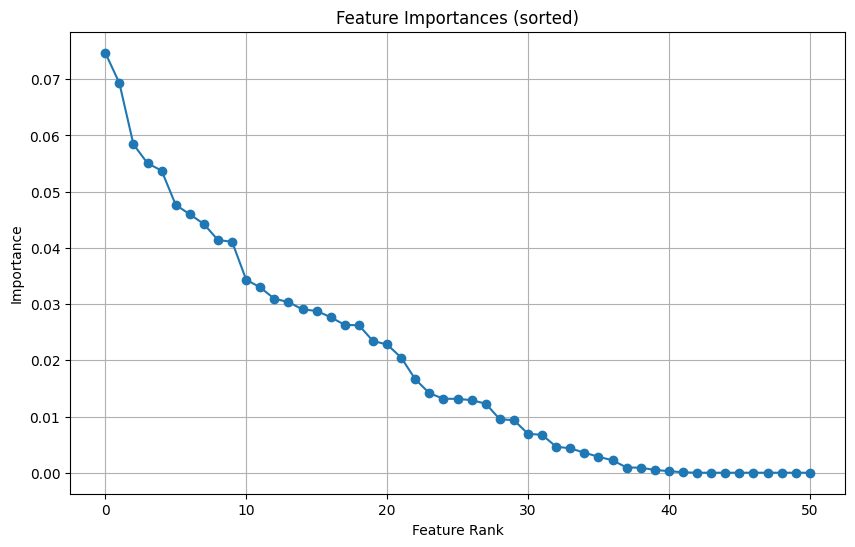

In [290]:
# Sort importances descending
sorted_importances = feature_importances_exp.filter(like="EVIL_BASTARD", axis=0).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.plot(np.arange(len(sorted_importances)), sorted_importances["Importance"].values, marker='o')
plt.title("Feature Importances (sorted)")
plt.xlabel("Feature Rank")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

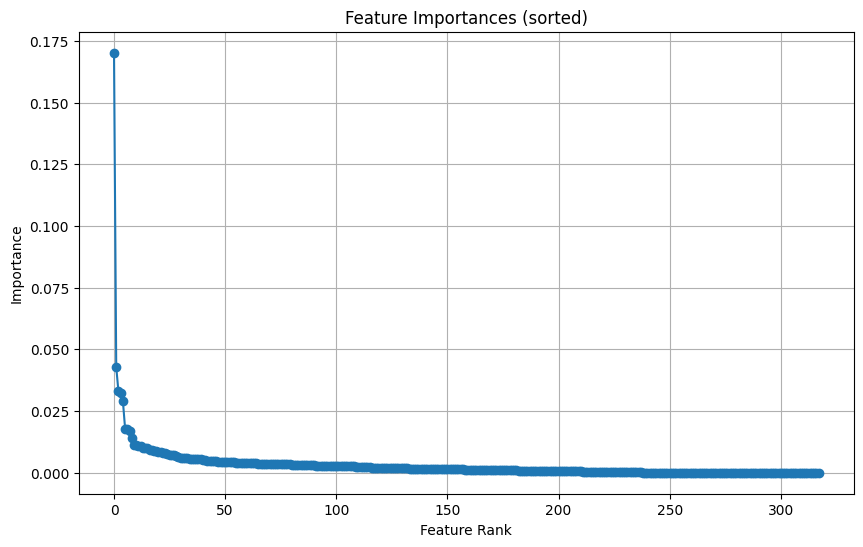

In [299]:
# Sort importances descending
sorted_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.plot(np.arange(len(sorted_importances)), sorted_importances["Importance"].values, marker='o')
plt.title("Feature Importances (sorted)")
plt.xlabel("Feature Rank")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

In [295]:
def get_important_features(feature_importances, by_experiment, curve='convex', 
                    direction='decreasing', min_features=3, max_features=None):
    """
    Select important features for each experiment using the knee/elbow method on feature importance values.
    
    Parameters:
    -----------
    feature_importances : DataFrame
        DataFrame with feature importances, index=feature names, columns=['Importance']
    experiments : list, optional (default=None)
        List of experiment prefixes to group features by. If None, will try to infer from feature names.
    curve : str, optional (default='convex')
        Type of curve to fit for knee detection ('convex' or 'concave')
    direction : str, optional (default='decreasing')
        Direction of values ('decreasing' or 'increasing')
    min_features : int, optional (default=3)
        Minimum number of features to select even if knee suggests fewer
    max_features : int, optional (default=None) 
        Maximum number of features to select regardless of knee
        
    Returns:
    --------
    important_features : dict
        Dictionary mapping experiment names to DataFrames of selected features with their importances
    summary : DataFrame
        DataFrame summarizing the number of features selected for each experiment
    """
    if by_experiment:
        experiments = ["ANTI_SACCADE", "FITTS_LAW", "FIXATIONS", "KING_DEVICK", "EVIL_BASTARD", "REACTION", "SHAPES", "SMOOTH_PURSUITS"]
    else:
        experiments = ["ALL"]
    
    # Store results
    selected_features = {}
    summary_rows = []
    
    for exp in experiments:
        # Get features for this experiment
        if exp == "ALL":
            feature_importances_exp = feature_importances
        else:
            feature_importances_exp = feature_importances.filter(like=exp,axis=0)
        
        # Sort features by importance
        sorted_features = feature_importances_exp.sort_values(by="Importance", ascending=False)
        importance_values = sorted_features["Importance"].values
        feature_ranks = np.arange(len(importance_values))

        # Find knee
        knee = KneeLocator(
            feature_ranks, 
            importance_values, 
            curve=curve, 
            direction=direction
        )
        knee_point = knee.knee

        if knee_point is not None:
            logging.info(f"{exp}: Knee detected at feature rank {knee_point}")
        else:
            logging.warning("Knee point is not detected")
            knee_point = len(feature_importances_exp) - 1

        # Select features above knee
        selected_features_exp = sorted_features.iloc[:knee_point+1]
        logging.info(f"Automatically selected {selected_features_exp.shape[0]} features")
        
        selected_features[exp]=selected_features_exp
        
        # Add summary data
        summary_rows.append({
            'Experiment': exp,
            'Total Features': len(feature_importances_exp),
            'Selected Features': len(selected_features_exp),
            'Selection %': round(len(selected_features_exp) / len(feature_importances_exp) * 100, 1),
            'Top Feature': selected_features_exp.index[0] if not selected_features_exp.empty else None,
            'Top Importance': selected_features_exp['Importance'].iloc[0] if not selected_features_exp.empty else None,
            'Method': "kneedle"
        })
         
    # Create summary dataframe
    summary = pd.DataFrame(summary_rows)
    
    # Concatenate all important features
    selected_features = pd.concat(selected_features.values(), keys=selected_features.keys()).reset_index(level=0, drop=True)
        
    return selected_features, summary

In [296]:
important_features, summary = get_important_features(feature_importances, by_experiment=False)
important_features_exp, summary_exp = get_important_features(feature_importances_exp, by_experiment=True)

2025-04-30 15:31:51,064 - INFO - 3159926972.get_important_features:59 - ALL: Knee detected at feature rank 9
2025-04-30 15:31:51,065 - INFO - 3159926972.get_important_features:66 - Automatically selected 10 features
2025-04-30 15:31:51,070 - INFO - 3159926972.get_important_features:59 - ANTI_SACCADE: Knee detected at feature rank 2
2025-04-30 15:31:51,071 - INFO - 3159926972.get_important_features:66 - Automatically selected 3 features
2025-04-30 15:31:51,074 - INFO - 3159926972.get_important_features:59 - FITTS_LAW: Knee detected at feature rank 3
2025-04-30 15:31:51,076 - INFO - 3159926972.get_important_features:66 - Automatically selected 4 features
2025-04-30 15:31:51,080 - INFO - 3159926972.get_important_features:59 - FIXATIONS: Knee detected at feature rank 8
2025-04-30 15:31:51,081 - INFO - 3159926972.get_important_features:66 - Automatically selected 9 features
2025-04-30 15:31:51,086 - INFO - 3159926972.get_important_features:59 - KING_DEVICK: Knee detected at feature rank 1
2

## Feature selection

In [297]:
feature_list = list(set(important_features.index).union(set(important_features_exp.index)).union(set(significant_features.feature)))

In [298]:
len(feature_list)

72

In [304]:
features[["participant_id", "y"] + feature_list]

,participant_id,y,SHAPES_duration_std_sacc,EVIL_BASTARD_amplitude_std_sacc,FITTS_LAW_saccades_per_second_median,REACTION_duration_max_sacc,EVIL_BASTARD_distance_to_fixpoint_y_max,KING_DEVICK_avg_pupil_size_std_fix,REACTION_reaction_time_avg,SHAPES_x_fixation_dist_mean,...,REACTION_amplitude_mean_sacc,EVIL_BASTARD_peak_velocity_mean_sacc,KING_DEVICK_wrong_direction_saccade_pct_std,EVIL_BASTARD_y_acceleration_std,SMOOTH_PURSUITS_distance_to_fixpoint_x_max,FITTS_LAW_y_acceleration_min,FITTS_LAW_duration_std_fix,ANTI_SACCADE_x_acceleration_max,SHAPES_peak_velocity_mean_sacc,EVIL_BASTARD_y_acceleration_max
1,138,1,NaN,4.363036,2.744533,5271.0,927488.05,376.049468,219.500000,NaN,...,2.882500,205.874016,2.884291,2954.771953,NaN,-243800.0,675.021677,375400.0,NaN,235200.0
3,106,1,56.803206,2.804883,3.039161,236.0,217622.25,191.391027,260.666667,61.711881,...,2.349213,116.038585,4.302666,1418.929884,1980274.410,-26600.0,113.960652,30700.0,169.731707,86000.0
4,151,1,153.893170,2.590864,2.971906,499.0,1129331.29,142.231504,320.166667,41.835000,...,1.198627,127.209591,1.845930,3869.345534,8678916.000,-330600.0,109.046784,1031000.0,225.389535,117300.0
6,135,0,135.174623,3.683620,3.669849,207.0,810000.00,421.800545,216.277778,42.756842,...,2.542945,327.098326,5.441379,3859.810363,207425.780,-70200.0,96.238326,27100.0,132.274809,156400.0
12,133,1,NaN,2.828215,2.969495,206.0,2876755.21,393.554502,284.000000,NaN,...,1.050385,188.970779,6.350356,4748.838873,NaN,-307000.0,129.980442,708800.0,NaN,333000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,379,0,71.392845,3.313037,2.971902,382.0,411393.96,205.186719,201.944444,74.284211,...,2.237899,162.260870,3.539040,2277.165513,4654374.760,-76800.0,153.142122,119400.0,178.729508,147600.0
188,402,0,152.254227,3.242462,2.048536,414.0,198737.64,363.662829,239.166667,56.540157,...,1.271600,141.332500,0.211746,2209.387314,1052757.205,-45600.0,198.000615,75400.0,164.902439,166000.0
189,395,1,107.362991,3.346377,2.138095,470.0,984460.84,249.199192,301.000000,38.682796,...,2.050108,273.418455,5.248577,4886.010604,5369415.840,-127800.0,268.889394,442600.0,414.825243,178400.0
190,401,0,204.430064,3.205020,2.611671,588.0,332698.24,234.572714,227.111111,101.690769,...,2.327664,183.789352,5.086400,3251.343295,350700.840,-33200.0,130.521730,95800.0,221.094118,173600.0
